# Extract threshold from eye roi

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io
import cv2
import math
import glob
from sklearn import mixture
from scipy.optimize import curve_fit
from ipywidgets import Button, IntSlider
import asyncio
%matplotlib notebook

In [2]:
ANIMALS = ["G405"]
PATH = "/home1/bhalla/hrishikeshn/"
np.random.seed(574)

In [3]:
def plot_eye_data(roi, animal_name, session, csv_error_trials, threshold):
    """Extract threshold for binarizing eye ROIs
    Parameters
    ----------
    roi : tuple
        Tuple of the eye ROI (xmin, ymin, xmax, ymax)
    animal_name : str
        Name of the animal
    session : pd.Series
        Pandas series of one row of the csv file
    csv_error_trials : set
        Set of trial numbers which have errors
    """
#     slider1 = IntSlider(min=0, max=256, value=70)
#     display(slider1)
    x_min, y_min, x_max, y_max = roi
    trials = []
    trials.append(np.random.choice(list(set(range(min(5,session['num_behaviour_trials']))) - csv_error_trials)))
    print(trials)
#     fig, ax = plt.subplots(2,4)
    for t, t_num in enumerate(trials):
        behav_file_name = f"{PATH}/BehaviorRawData/{animal_name}/{animal_name}_{session['behaviour_code']}_{session['upi']}/{t_num:03}.tiff"
        frame_stack = io.imread(behav_file_name)
        if int(t/2) == 0:
            frame_num = np.random.choice(200)
        else:
            frame_num = np.random.choice(range(200, len(frame_stack)))
        print(frame_num)
        eye_roi = frame_stack[frame_num][y_min:y_max, x_min:x_max]
        ax[int(t/2), (t%2)*2].imshow(eye_roi, cmap="gray")
        median_filtered = cv2.medianBlur(eye_roi, 5)
        median_filtered_binarized = median_filtered > slider.value
        ax[int(t/2), (t%2)*2 + 1].imshow(median_filtered_binarized, cmap="gray")

In [4]:
def handle_slider_change(change, roi):
    print(roi)
    plot_eye_data(roi, animal_name, session, csv_error_trials, change.new)

In [5]:
async def main():
    for animal_name in ANIMALS:
        csv_file = f"../csv/{animal_name}.csv"
        csv_data = pd.read_csv(csv_file, delimiter=",", dtype={
                'upi': int,
                'xmin:ymin': str,
                'xmax:ymax': str,
                'num_behaviour_trials': np.int64,
                'missing_behaviour_trials': str,
                'skip_behaviour_trials': str,
                'behaviour_code': str,
            },)
        for _, session in csv_data.iterrows(): 
            print(type(session))
            csv_error_trials = set()
            if pd.notna(session['skip_imaging_trials']):
                csv_error_trials.update([int(x) for x in session['skip_imaging_trials'].split(';')])
            if pd.notna(session['missing_imaging_trials']):
                csv_error_trials.update(int(x) for x in session['missing_imaging_trials'].split(';'))
            if session['num_behaviour_trials'] - len(csv_error_trials) > 0:
                # read roi
                xmin, ymin = [int(i) for i in session['xmin:ymin'].split(":")]
                xmax, ymax = [int(i) for i in session['xmax:ymax'].split(":")]
                roi = (xmin, ymin, xmax, ymax)
#                 print(roi)
                
                threshold = get_threshold(roi, animal_name, session, csv_error_trials)
                
            else:
                print(f"All trials in session {session['date']} of animal {animal_name} have issues")
            break

#             print(upi)
#     xmin, ymin = [int(i) for i in csv_data.loc[csv_data["upi"]==session_upi, "xmin:ymin"].iloc[0].split(":")]
#     xmax, ymax = [int(i) for i in csv_data.loc[csv_data["upi"]==session_upi, "xmax:ymax"].iloc[0].split(":")]
#     print(xmin, ymin, xmax, ymax) 

In [6]:
def wait_for_change(widget, slider_widget):
    future = asyncio.Future()
    def getvalue(change):
        future.set_result(slider_widget.value)
        widget.on_click(getvalue, remove=True) 
        # we need to free up the binding to getvalue to avoid an InvalidState error
        # buttons don't support unobserve
        # so use `remove=True` 
    widget.on_click(getvalue)
    return future

In [7]:
async def f(animal_name, slider):
    csv_file = f"../csv/{animal_name}.csv"
    csv_data = pd.read_csv(csv_file, delimiter=",", dtype={
            'upi': int,
            'xmin:ymin': str,
            'xmax:ymax': str,
            'num_behaviour_trials': np.int64,
            'missing_behaviour_trials': str,
            'skip_behaviour_trials': str,
            'behaviour_code': str,
        },)
    thresholds = []
    for i, session in csv_data.iterrows(): 
        print(type(session))
        fig, ax = plt.subplots(2,4)
        csv_error_trials = set()
        if pd.notna(session['skip_imaging_trials']):
            csv_error_trials.update([int(x) for x in session['skip_imaging_trials'].split(';')])
        if pd.notna(session['missing_imaging_trials']):
            csv_error_trials.update(int(x) for x in session['missing_imaging_trials'].split(';'))
        if session['num_behaviour_trials'] - len(csv_error_trials) > 0:
            # read roi
            xmin, ymin = [int(i) for i in session['xmin:ymin'].split(":")]
            xmax, ymax = [int(i) for i in session['xmax:ymax'].split(":")]
            roi = (xmin, ymin, xmax, ymax)
            print(roi)
#             slider.observe(handle_slider_change(roi), names='value')
            interact(plot_eye_data, threshold=slider, roi=roi, animal_name=animal_name, session=session,
                     csv_error_trials=csv_error_trials) 
    
#             slider.on_changed(plot_eye_data(roi, animal_name, session, csv_error_trials, slider.value))
            x = await wait_for_change(button, slider)
        else:
            x = np.nan
        print(f"Recorded threshold of {x} for {session['date']}_{session['behaviour_code']}")
        thresholds.append(x)
    print(thresholds)



IntSlider(value=70, max=256)

Button(description='Record threshold', style=ButtonStyle())

<class 'pandas.core.series.Series'>


<IPython.core.display.Javascript object>


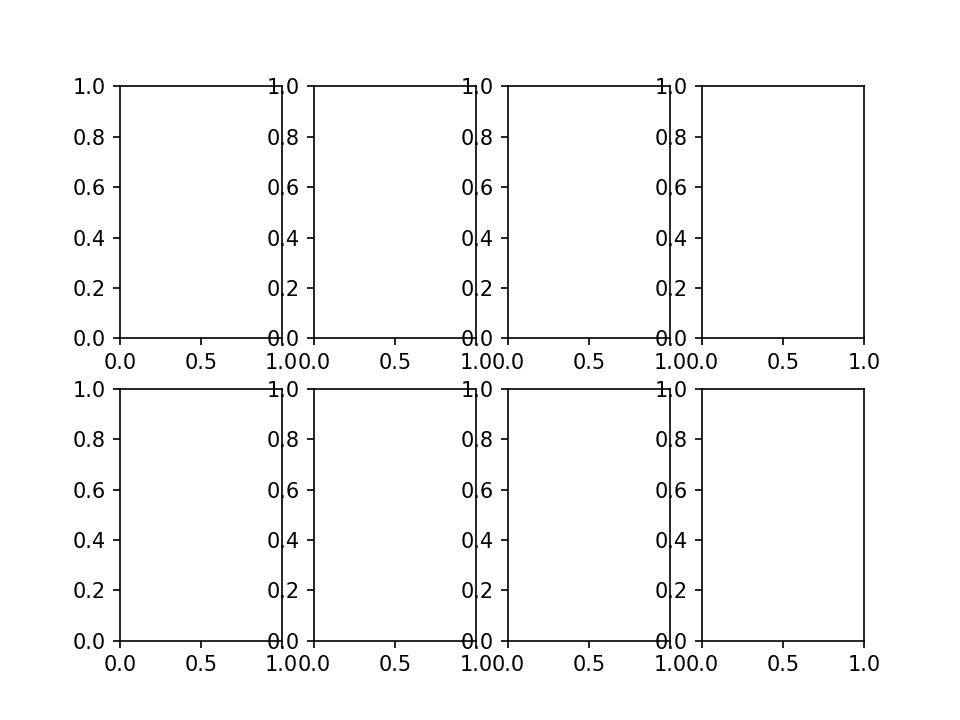

Task exception was never retrieved
future: <Task finished name='Task-4' coro=<f() done, defined at /tmp/ipykernel_771033/4214561612.py:1> exception=NameError("name 'interact' is not defined")>
Traceback (most recent call last):
  File "/tmp/ipykernel_771033/4214561612.py", line 28, in f
    interact(plot_eye_data, threshold=slider, roi=roi, animal_name=animal_name, session=session,
NameError: name 'interact' is not defined


(400, 110, 430, 260)


In [8]:
slider = IntSlider(min=0, max=256, value=70)
button = Button(description="Record threshold")
display(slider)

for animal_name in ANIMALS:
    asyncio.create_task(f("G405", slider))
button

In [ ]:
import ipywidgets as widgets
caption = widgets.Label(value='The values of range1 and range2 are synchronized')
slider = widgets.IntSlider(min=-5, max=5, value=1, description='Slider')

def handle_slider_change(change):
    caption.value = 'The slider value is ' + (
        'negative' if change.new < 0 else 'nonnegative'
    )

slider.observe(handle_slider_change, names='value')

display(caption, slider)

<IPython.core.display.Javascript object>


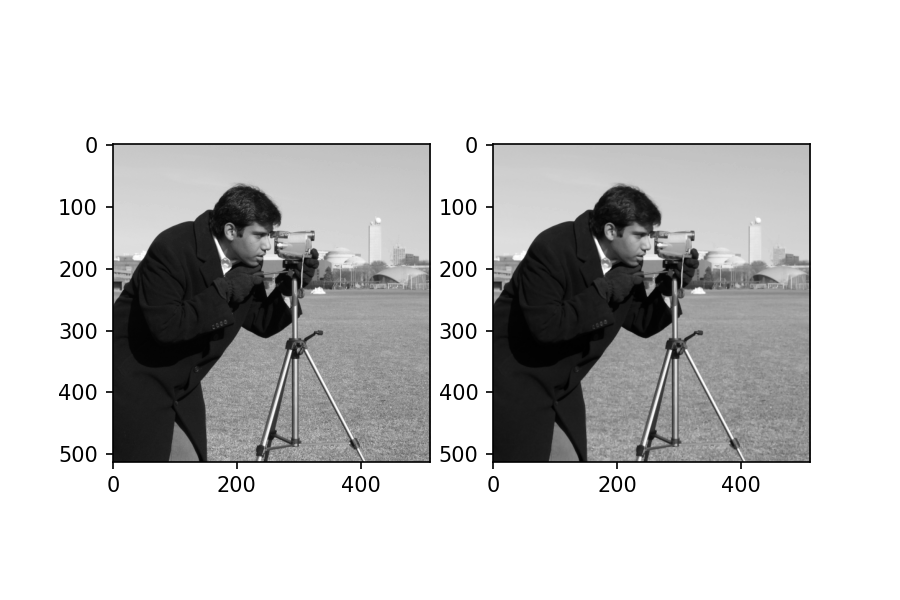

interactive(children=(IntSlider(value=1, description='Median_Size', max=21, min=1, step=2), Output()), _dom_cl…

<function __main__.f(Median_Size)>

In [11]:
%matplotlib notebook
from ipywidgets import interact, widgets
import matplotlib.pyplot as plt
import warnings

from skimage.morphology import disk
from skimage.filters import rank
from skimage.color import rgb2gray
import skimage.data


def f(Median_Size):
    selem = disk(int(Median_Size))
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        img_median = rank.median(img_gray, selem=selem) 

    ax_neu.imshow(img_median, cmap="gray")
    fig.canvas.draw()
    #plt.imshow(img_median, cmap="gray") #This would work
    #plt.show()

img_gray = skimage.data.camera() #plt.imread("Test.png")       
# img_gray = rgb2gray(image)

fig = plt.figure(figsize=(6, 4))
ax_orig = fig.add_subplot(121) 
ax_neu = fig.add_subplot(122) 

ax_orig.imshow(img_gray, cmap="gray")
ax_neu.imshow(img_gray, cmap="gray")

interact(f, Median_Size=widgets.IntSlider(min=1,max=21,step=2,value=1)) 


In [1]:
def update_figure(threshold):
    for i in range(6):
        binarized = median_filtered[i] > threshold
        ax[i*2 + 1].imshow(binarized, cmap="gray")
    fig.canvas.draw()
    #plt.imshow(img_median, cmap="gray") #This would work
    #plt.show()

In [2]:
roi = skimage.data.camera() #plt.imread("Test.png")       
# img_gray = rgb2gray(image)

fig, ax = plt.subplots(1, 6, figsize=(6, 4))

median_filtered = []
median_filtered.append(cv2.medianBlur(roi, 5))
median_filtered.append(cv2.medianBlur(roi, 5))
median_filtered.append(cv2.medianBlur(roi, 5))
for i in range(3):
    ax[i*2].imshow(img_gray, cmap="gray")

interact(update_figure, threshold=widgets.IntSlider(min=1,max=256,step=1,value=1)) 

NameError: name 'skimage' is not defined